# Measurements of Relativistic Biases

Start in the appropriate notebook directory.

In [1]:
# %cd /mnt/lustre/mikewang/projects/HorizonGRound/notebooks/

Set up the appropriate paths.

In [2]:
import os, sys

current_file_dir = os.getcwd()
sys.path.insert(0, "".join([current_file_dir, "/../"]))
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

from config.program import data_dir, stylesheet

publication_dir = data_dir/"output"/"publication"

Import the appropriate packages.

In [3]:
import glob
import re
from collections import defaultdict

import corner
import h5py
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.ticker import AutoMinorLocator

plt.style.use(stylesheet)

## Relativistic bias quantiles

In [4]:
extracted_chain_files = glob.glob("/".join([str(publication_dir), "dense_points", "relbias_z*"]))

In [5]:
quantile_levels = [0.022750, 0.158655, 0.5, 0.841345, 0.977250]

In [6]:
dense_redshifts = []
evolution_bias_quantiles = defaultdict(list)
magnification_bias_quantiles = defaultdict(list)
for chain_file in sorted(extracted_chain_files):
    dense_redshifts.append(float(re.search("_z(?P<redshift>.*?)_", chain_file).group('redshift')))
    with h5py.File(chain_file, 'r') as chain_data:
        extracts = chain_data['extract/chain'][()]
        evol_b_q = corner.quantile(extracts[:, 0], q=quantile_levels)
        magn_b_q = corner.quantile(extracts[:, 1], q=quantile_levels)
    for sigma_level_idx, sigma_level in enumerate([-2, -1, 0, 1, 2]):
        evolution_bias_quantiles[sigma_level].append(evol_b_q[sigma_level_idx])
        magnification_bias_quantiles[sigma_level].append(magn_b_q[sigma_level_idx])

In [7]:
discontinuity_pos = np.searchsorted(dense_redshifts, 2.2)

if dense_redshifts[discontinuity_pos] == 2.2:
    del dense_redshifts[discontinuity_pos]
    for sigma_level in evolution_bias_quantiles:
        del evolution_bias_quantiles[sigma_level][discontinuity_pos]
        del magnification_bias_quantiles[sigma_level][discontinuity_pos]

low_redshift_part = slice(0, discontinuity_pos)
high_redshift_part = slice(discontinuity_pos, None)

## Relativistic bias measurements

In [8]:
measured_chain_files = glob.glob("/".join([str(publication_dir), "eBOSS_binning", "relbias_z*"]))

In [9]:
estimate_levels = [0.158655, 0.5, 0.841345]

In [10]:
measured_redshifts = []
evolution_bias_estimates = defaultdict(list)
magnification_bias_estimates = defaultdict(list)
for chain_file in sorted(measured_chain_files):
    measured_redshifts.append(float(re.search("_z(?P<redshift>.*?)_", chain_file).group('redshift')))
    with h5py.File(chain_file, 'r') as chain_data:
        extracts = chain_data['extract/chain'][()]
        evol_b_e = corner.quantile(extracts[:, 0], q=estimate_levels)
        magn_b_e = corner.quantile(extracts[:, 1], q=estimate_levels)
    for sigma_level_idx, sigma_level in enumerate([-1, 0, 1]):
        evolution_bias_estimates[sigma_level].append(evol_b_e[sigma_level_idx])
        magnification_bias_estimates[sigma_level].append(magn_b_e[sigma_level_idx])

## Relativistic bias constraints

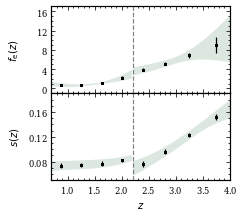

In [11]:
LINESTYLE = '-'
COLOUR = '#A3C1AD'
ALPHA = 0.75

fig = plt.figure("relativistic biases", figsize=(3.2, 3.2))

# Evolution bias

evolution = plt.subplot2grid((2, 1), (0, 0))

evolution.errorbar(
    measured_redshifts, evolution_bias_estimates[0], 
    yerr=[
        np.subtract(evolution_bias_estimates[0], evolution_bias_estimates[-1]),
        np.subtract(evolution_bias_estimates[1], evolution_bias_estimates[0]),
    ],
    fmt='s', zorder=3
)
for part in [low_redshift_part, high_redshift_part]:
    evolution.fill_between(
        dense_redshifts[part], evolution_bias_quantiles[-2][part], evolution_bias_quantiles[2][part],
        facecolor=COLOUR, alpha=0.5*ALPHA, zorder=1
    )

evolution.axvline(x=2.2, ls='--', c='0.5')

evolution.tick_params(axis='x', which='both', labelbottom=False)
evolution.set_yticks(np.arange(-4., 20., step=4.))
evolution.xaxis.set_minor_locator(AutoMinorLocator())
evolution.yaxis.set_minor_locator(AutoMinorLocator())
evolution.set_xlim(min(dense_redshifts), max(dense_redshifts))
evolution.set_ylim(-1., 17.)
evolution.set_ylabel(r"$f_\mathrm{e}(z)$", labelpad=15)

# Magnification bias

magnification = plt.subplot2grid((2, 1), (1, 0), sharex=evolution)

magnification.errorbar(
    measured_redshifts, magnification_bias_estimates[0],  
    yerr=[
        np.subtract(magnification_bias_estimates[0], magnification_bias_estimates[-1]),
        np.subtract(magnification_bias_estimates[1], magnification_bias_estimates[0]),
    ],
    fmt='s', zorder=3
)
for part in [low_redshift_part, high_redshift_part]:
    magnification.fill_between(
        dense_redshifts[part], magnification_bias_quantiles[-2][part], magnification_bias_quantiles[2][part],
        facecolor=COLOUR, alpha=0.5*ALPHA, zorder=1
    )
    
magnification.axvline(x=2.2, ls='--', c='0.5')

magnification.set_yticks(np.arange(0., 0.2, step=0.04))
magnification.yaxis.set_minor_locator(AutoMinorLocator())
magnification.set_ylim(0.05, 0.19)
magnification.set_xlabel(r"$z$", labelpad=5)
magnification.set_ylabel(r"$s(z)$", labelpad=7)

fig.savefig(publication_dir/"gallery"/"relativistic_biases.pdf")